# Target vs pScore Analysis
This notebook looks at how pScores compare to number of unique (protein) targets for each scaffold, as well as protein families.

# Setup

In [1]:
# define DB variables
DB_NAME = "badapple2"
DB_HOST = "localhost"
DB_USER = "jack"
DB_PASSWORD = "Fletcher12"
# path to list of assayIDs in DB
AID_PATH = "/home/jack/unm_gra/data/badapple/badapple2/badapple2_tested.aid"

In [2]:
# imports
import psycopg2
import psycopg2.extras
from psycopg2 import sql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter
import seaborn as sns

## Connect to DB

In [3]:
def db_connect(db_name: str, host: str, user: str, password: str):
    try:
        db_connection = psycopg2.connect(
            dbname=db_name,
            host=host,
            user=user,
            password=password,
            cursor_factory=psycopg2.extras.DictCursor,
        )
        db_connection.set_session(readonly=True)
        return db_connection
    except Exception as e:
        print(e)
        print(f"Error connecting to DB: {db_name}")
        return None

In [4]:
db_connection = db_connect(DB_NAME, DB_HOST, DB_USER, DB_PASSWORD)

In [5]:
db_cur = db_connection.cursor()

## Read AID File

In [6]:
def read_aid_file(aid_file_path: str) -> list[int]:
    with open(aid_file_path, "r") as file:
        aid_list = [int(line.strip()) for line in file if line.strip().isdigit()]
    return aid_list

In [7]:
AID_LIST = read_aid_file(AID_PATH)

# Gather Data

In [8]:
def get_result(query, db_cursor, db_conn):
    result = []
    try:
        db_cursor.execute(query)
        result = db_cursor.fetchall()
        return result
    except Exception:
        db_conn.rollback()
    return result

In [9]:
def get_data(db_cursor, db_conn, columns: str, table: str):
    query = sql.SQL(f"SELECT {columns} FROM {table}")
    return get_result(query, db_cursor, db_conn)

In [10]:
def get_data_df(db_cursor, db_conn, db_cols: str, db_table: str, df_cols: list[str]):
    data = get_data(db_cursor, db_conn, db_cols, db_table)
    df = pd.DataFrame(data, columns=df_cols)
    return df

## Get Scaffold IDs and pScores

In [11]:
pscore_df = get_data_df(db_cur, db_connection, "id,pscore", "scaffold", ["scafid", "pscore"])
pscore_df.dropna(subset=["pscore"], inplace=True)

In [12]:
pscore_df

,scafid,pscore
1,1084,84.0
2,1168,58.0
3,55051,14.0
8,2050,6.0
17,2997,5.0
...,...,...
469162,3218,4.0
469169,248,193.0
469191,26489,4.0
469197,0,1.0


## Get Targets and Assays

In [13]:
TARGET_COLUMNS = "target_id,type,external_id,external_id_type,name,taxonomy,taxonomy_id,protein_family"
TARGET_COLUMNS_LIST =  TARGET_COLUMNS.split(",")

In [14]:
target_df = get_data_df(db_cur, db_connection, TARGET_COLUMNS, "target", TARGET_COLUMNS_LIST)

In [15]:
target_df

,target_id,type,external_id,external_id_type,name,taxonomy,taxonomy_id,protein_family
0,1,Protein,1Y7V_A,NCBI,"Chain A, Glucosylceramidase",Homo sapiens (human),9606.0,None
1,2,Protein,Q02499,UniProt,Pyruvate kinase,Geobacillus stearothermophilus,1422.0,None
2,3,Protein,P30305,UniProt,M-phase inducer phosphatase 2,Homo sapiens (human),9606.0,Enzyme
3,4,Protein,Q99500,UniProt,Sphingosine 1-phosphate receptor 3,Homo sapiens (human),9606.0,GPCR
4,5,Protein,P28562,UniProt,Dual specificity protein phosphatase 1,Homo sapiens (human),9606.0,Enzyme
...,...,...,...,...,...,...,...,...
592,593,Protein,P11086,UniProt,Phenylethanolamine N-methyltransferase,Homo sapiens (human),9606.0,Enzyme
593,594,Protein,P21964,UniProt,Catechol O-methyltransferase,Homo sapiens (human),9606.0,Enzyme
594,595,Protein,P40261,UniProt,Nicotinamide N-methyltransferase,Homo sapiens (human),9606.0,Enzyme
595,596,Protein,Q14353,UniProt,Guanidinoacetate N-methyltransferase,Homo sapiens (human),9606.0,Enzyme


In [16]:
protein_target_df = target_df[target_df["type"] == "Protein"]
protein_target_df[["target_id", "protein_family"]]

,target_id,protein_family
0,1,None
1,2,None
2,3,Enzyme
3,4,GPCR
4,5,Enzyme
...,...,...
592,593,Enzyme
593,594,Enzyme
594,595,Enzyme
595,596,Enzyme


## Get Scaffold2Target Map

In [17]:
def get_scaf2target(db_cursor, db_conn):
    query = sql.SQL(
        """
SELECT 
scaf2activeaid.scafid,
aid2target.target_id
FROM 
aid2target 
RIGHT JOIN  
scaf2activeaid 
ON aid2target.aid = scaf2activeaid.aid;
"""
    )
    return get_result(query, db_cursor, db_conn)

In [18]:
scaf2target_data = get_scaf2target(db_cur, db_connection)

In [19]:
scaf2target_df = pd.DataFrame(scaf2target_data, columns=["scafid", "target_id"], dtype=pd.Int64Dtype())

In [20]:
scaf2target_df

,scafid,target_id
0,0,1
1,0,<NA>
2,0,<NA>
3,0,<NA>
4,0,92
...,...,...
2653454,467320,595
2653455,467320,594
2653456,467320,593
2653457,467320,592


In [21]:
pd.isna(scaf2target_df["target_id"].iloc[0])

False

In [22]:
scaf2target_nonan_df = scaf2target_df.dropna(axis=0, how="any")

In [23]:
scaf2target_nonan_df

,scafid,target_id
0,0,1
4,0,92
5,0,91
6,0,217
7,0,462
...,...,...
2653454,467320,595
2653455,467320,594
2653456,467320,593
2653457,467320,592


In [24]:
scaf2prottarget_df = scaf2target_nonan_df[scaf2target_nonan_df["target_id"].isin(protein_target_df["target_id"])]

In [25]:
scaf2prottarget_df

,scafid,target_id
0,0,1
4,0,92
5,0,91
6,0,217
7,0,462
...,...,...
2653454,467320,595
2653455,467320,594
2653456,467320,593
2653457,467320,592


In [26]:
merged_df = pd.merge(scaf2prottarget_df, pscore_df, on="scafid", how="right")

In [27]:
merged_df

,scafid,target_id,pscore
0,1084,1,84.0
1,1084,23,84.0
2,1084,27,84.0
3,1084,36,84.0
4,1084,37,84.0
...,...,...,...
1964210,1,553,64.0
1964211,1,552,64.0
1964212,1,555,64.0
1964213,1,557,64.0


# Make Plots

1. Group scaffolds by pScore into low, moderate, high categories
2. For each category (low, moderate, high) plot:
    - Number of unique protein targets per scaffold
    - Number of unique protein families per scaffold

In [28]:
PSCORE_CATEGORIES = ['Low pScore', 'Moderate pScore', 'High pScore']
PSCORE_COLORS = ["green", "yellow", "red"]

In [29]:
def classify_pScore(pScore):
    if pScore is None:
        return None
    elif pScore < 100:
        return PSCORE_CATEGORIES[0]
    elif pScore < 300:
        return PSCORE_CATEGORIES[1]
    else:
        return PSCORE_CATEGORIES[2]

In [30]:
def create_histogram_plots(stats_df: pd.DataFrame, bins: np.ndarray, x_col: str, xlabel: str, 
                           xlim: tuple, ylim: tuple, colors: list[str] = PSCORE_COLORS,
                           category_col: str = "pScore_category", categories: list[str] = PSCORE_CATEGORIES, n_rows: int =1,
                           save_fname: str = None):
    n_cols = len(categories) // n_rows
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=True, figsize=(15, 5))
    axes = axes.flatten()
    for i, category in enumerate(categories):
        ax = axes[i]
        subset = stats_df[stats_df[category_col] == category]
        sns.histplot(subset[x_col], ax=axes[i], bins=bins, kde=False, color=colors[i], stat="percent")
        ax.set_title(f"{category}\nN={len(subset)}")
        ax.set_xlabel(xlabel)
        ax.set_xlim(xlim)
        ax.set_ylabel("Relative Frequency (%)")


    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
    plt.ylim(ylim)
    plt.tight_layout()
    if save_fname is not None:
        plt.savefig(save_fname, dpi=300)
    plt.show()

In [31]:
def create_boxplots(stats_df: pd.DataFrame, x_col: str, y_col: str, hue_col: str, yscale: str, ylabel: str, title: str,
                    whiskers: tuple = (0,100), pallette=PSCORE_COLORS, xlabel: str = "",
                    linthresh = None, ylim: tuple = None, save_fname: str = None):
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=stats_df, x=x_col, y=y_col, hue=hue_col, palette=pallette, whis=whiskers)
    plt.yscale(yscale)
    if linthresh is not None:
        plt.yscale(yscale, linthresh=linthresh)
    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.tight_layout()
    if save_fname is not None:
        plt.savefig(save_fname, dpi=300)
    plt.show()

In [32]:
# for float vals
nan_set = set([np.nan])
# for int vals
null_val_set = set([pd.NA])

## Plot Unique Targets

In [33]:
scaf_stats = merged_df.groupby("scafid").agg(
    unique_targets=("target_id", lambda x: len(set(x) - null_val_set)),
    pscore=("pscore", "first")
).reset_index()

In [34]:
scaf_stats["pScore_category"] = scaf_stats["pscore"].apply(classify_pScore)

In [35]:
scaf_stats

,scafid,unique_targets,pscore,pScore_category
0,0,8,1.0,Low pScore
1,1,136,64.0,Low pScore
2,2,549,158.0,Moderate pScore
3,3,540,428.0,High pScore
4,4,8,1.0,Low pScore
...,...,...,...,...
148316,206843,4,1.0,Low pScore
148317,206845,45,64.0,Low pScore
148318,206846,45,64.0,Low pScore
148319,211790,1,0.0,Low pScore


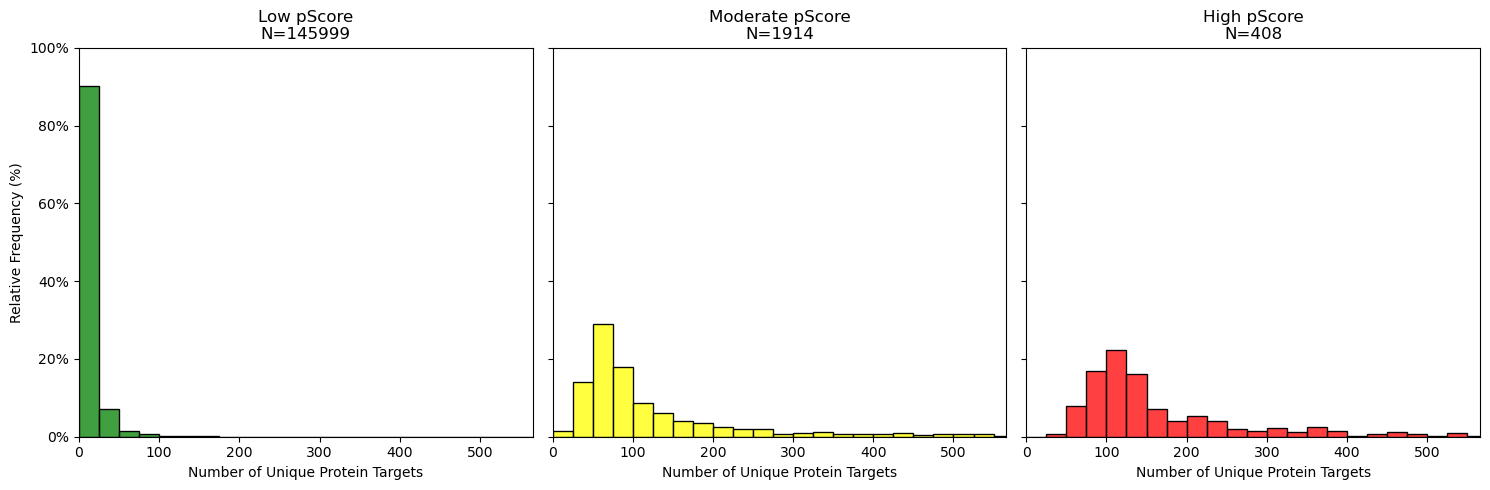

In [36]:
bins = np.arange(0, len(protein_target_df) + 25, 25)
x_col = "unique_targets"
xlabel = "Number of Unique Protein Targets"
xlim = (0, len(protein_target_df))
ylim = (0, 100)
create_histogram_plots(scaf_stats, bins, x_col, xlabel, xlim, ylim, save_fname="unique_targets_hist.png")

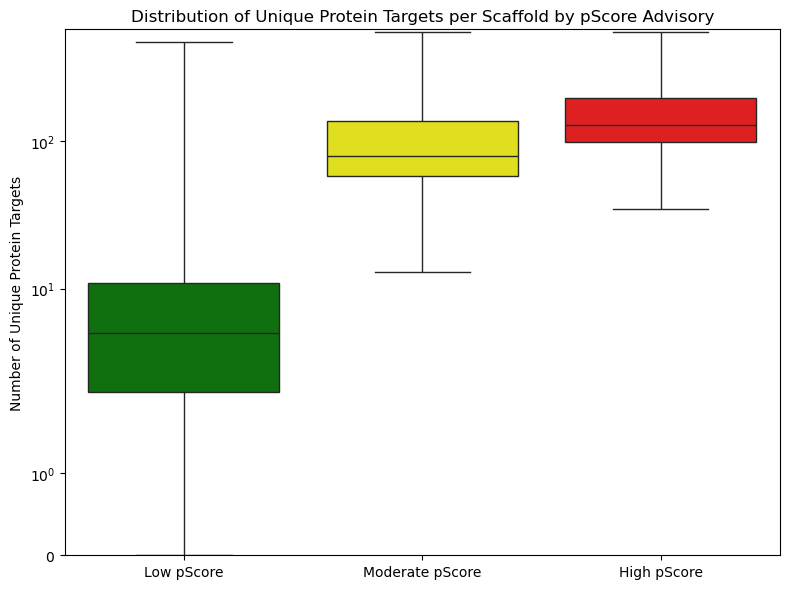

In [37]:
create_boxplots(scaf_stats, "pScore_category", "unique_targets", "pScore_category", 
                "symlog", "Number of Unique Protein Targets", 
                "Distribution of Unique Protein Targets per Scaffold by pScore Advisory",
                linthresh=None, ylim=(0, len(protein_target_df) + 10), save_fname="unique_targets_boxplot.png")

## Plot Unique Protein Families

In [38]:
protein_family_df = protein_target_df.dropna(subset=["protein_family"])[["target_id", "protein_family"]]

# handle special case where N=2 proteins classified as both TF and Epigenetic 
idx = protein_family_df["protein_family"] == "TF; Epigenetic"
target_ids = protein_family_df.loc[idx, "target_id"]
# reset to TF
protein_family_df.loc[idx, "protein_family"] = "TF"
# add entry for Epigenetic
new_rows = [
    {'target_id': target_ids.iloc[0], 'protein_family': "Epigenetic"},
    {'target_id': target_ids.iloc[1], 'protein_family': "Epigenetic"}
]
df_app = pd.DataFrame(new_rows, columns=protein_family_df.columns)
protein_family_df = pd.concat([protein_family_df, df_app], ignore_index=True)
print(protein_family_df[protein_family_df["target_id"].isin(target_ids)])

     target_id protein_family
121        307             TF
176        454             TF
222        307     Epigenetic
223        454     Epigenetic


In [39]:
protein_family_df

,target_id,protein_family
0,3,Enzyme
1,4,GPCR
2,5,Enzyme
3,12,Enzyme
4,13,GPCR
...,...,...
219,594,Enzyme
220,595,Enzyme
221,596,Enzyme
222,307,Epigenetic


In [40]:
scaf2fam_df = pd.merge(merged_df, protein_family_df, how="left", on="target_id")

In [41]:
scaf2fam_df

,scafid,target_id,pscore,protein_family
0,1084,1,84.0,NaN
1,1084,23,84.0,NR
2,1084,27,84.0,NaN
3,1084,36,84.0,GPCR
4,1084,37,84.0,NaN
...,...,...,...,...
1969288,1,553,64.0,NaN
1969289,1,552,64.0,NaN
1969290,1,555,64.0,NaN
1969291,1,557,64.0,NaN


In [42]:
scaf_family_stats = scaf2fam_df.groupby("scafid").agg(
    unique_protein_families=("protein_family", lambda x: len(set(x) - nan_set)),
    pscore=("pscore", "first")
).reset_index()

In [43]:
scaf_family_stats["pScore_category"] = scaf_family_stats["pscore"].apply(classify_pScore)

In [44]:
scaf_family_stats

,scafid,unique_protein_families,pscore,pScore_category
0,0,0,1.0,Low pScore
1,1,8,64.0,Low pScore
2,2,8,158.0,Moderate pScore
3,3,8,428.0,High pScore
4,4,0,1.0,Low pScore
...,...,...,...,...
148316,206843,1,1.0,Low pScore
148317,206845,4,64.0,Low pScore
148318,206846,4,64.0,Low pScore
148319,211790,0,0.0,Low pScore


In [45]:
family_set = set(protein_family_df["protein_family"])
total_n_families = len(family_set)
family_set 

{'Enzyme', 'Epigenetic', 'GPCR', 'IC', 'Kinase', 'NR', 'TF', 'Transporter'}

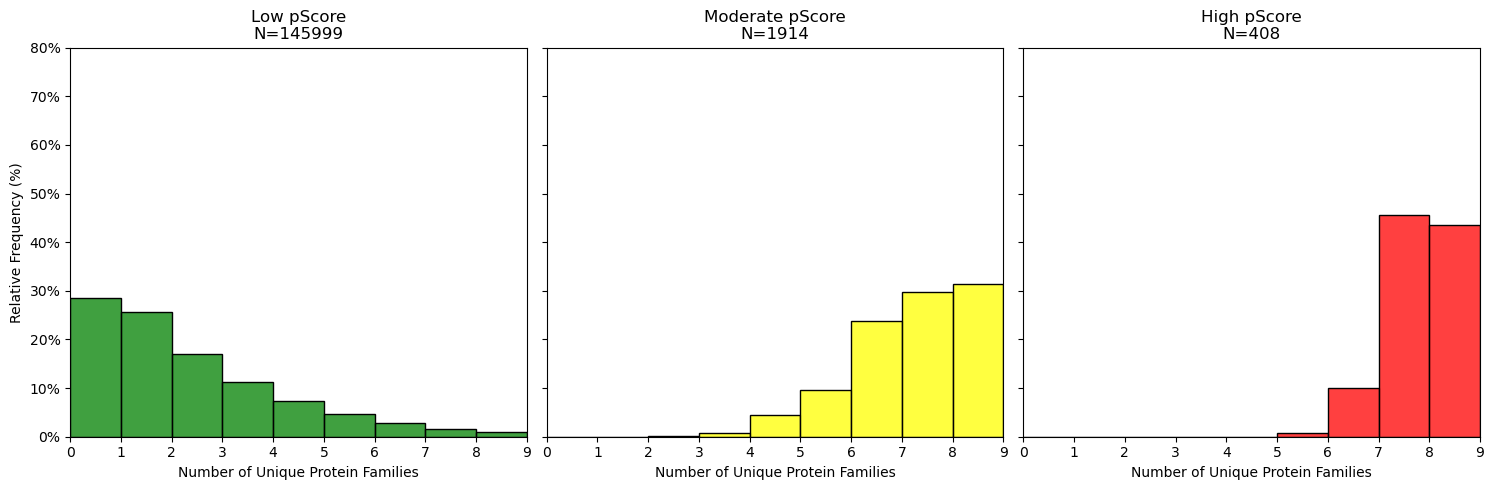

In [46]:
bins = np.arange(0, 11, 1)
x_col = "unique_protein_families"
xlabel = "Number of Unique Protein Families"
xlim = (0, total_n_families + 1)
ylim = (0, 80)
create_histogram_plots(scaf_family_stats, bins, x_col, xlabel, xlim, ylim, save_fname="n_families_hist.png")

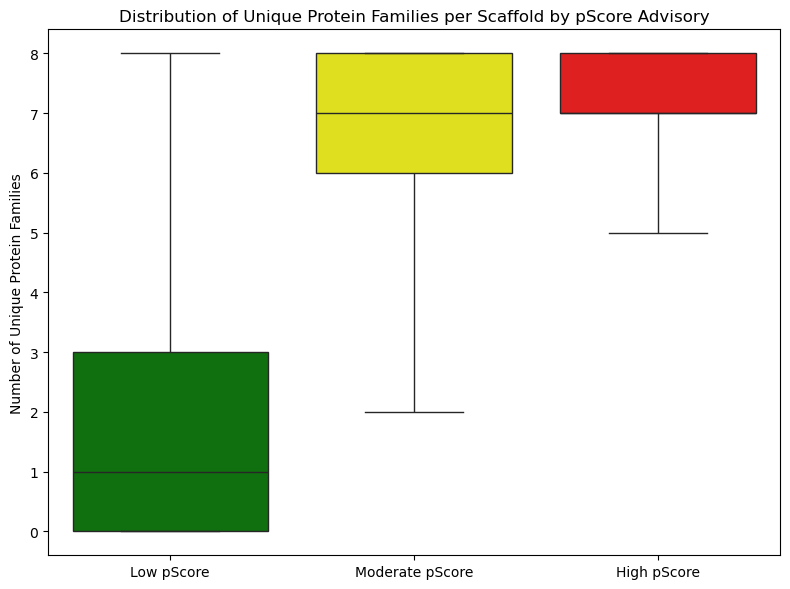

In [47]:
create_boxplots(scaf_family_stats, "pScore_category", "unique_protein_families", "pScore_category", 
                "linear", "Number of Unique Protein Families", 
                "Distribution of Unique Protein Families per Scaffold by pScore Advisory", save_fname="n_families_boxplot.png")

## Plot pScore Distribution by Target Family

In [48]:
scaf2fam_nonan_df = scaf2fam_df.dropna(subset="protein_family")

In [49]:
scaf2fam_nonan_df = scaf2fam_nonan_df.sort_values(by="protein_family")
scaf2fam_nonan_df

,scafid,target_id,pscore,protein_family
1969292,1,155,64.0,Enzyme
1419418,159137,242,1.0,Enzyme
605378,2199,170,422.0,Enzyme
605380,2199,177,422.0,Enzyme
1419411,159131,323,1.0,Enzyme
...,...,...,...,...
94445,4048,320,29.0,Transporter
524207,154844,418,17.0,Transporter
1728357,87641,136,293.0,Transporter
51927,1504,79,20.0,Transporter


In [50]:
fam_categories = sorted(list(family_set))
fam_categories

['Enzyme', 'Epigenetic', 'GPCR', 'IC', 'Kinase', 'NR', 'TF', 'Transporter']

In [51]:
n_colors = 8
color_i = np.linspace(0, 1, n_colors)
cmap = plt.get_cmap("Set2")
fam_colors = [cmap(i) for i in color_i]

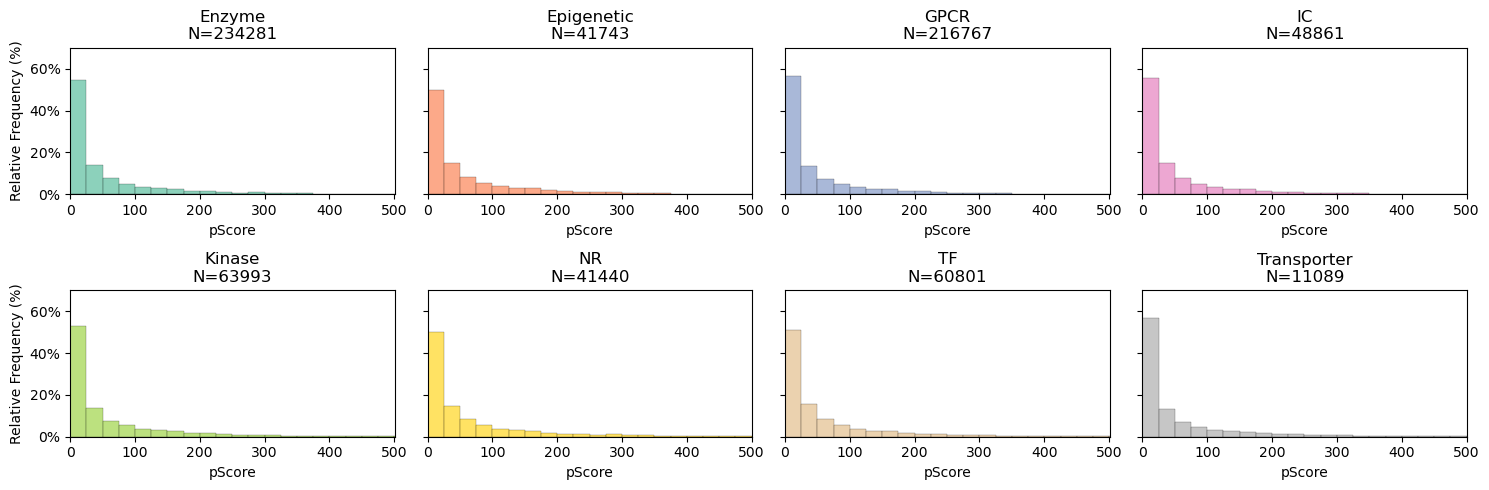

In [52]:
max_pscore = scaf2fam_df["pscore"].max()
bins = np.arange(0,  max_pscore + 25, 25)
x_col = "pscore"
xlabel = "pScore"
xlim = (0, 500 + 1)
ylim = (0, 70)
create_histogram_plots(scaf2fam_nonan_df, bins, x_col, xlabel, xlim, ylim, 
                       colors=fam_colors, category_col="protein_family", 
                       categories=fam_categories, n_rows=2, save_fname="pscores_by_family_hist.png")

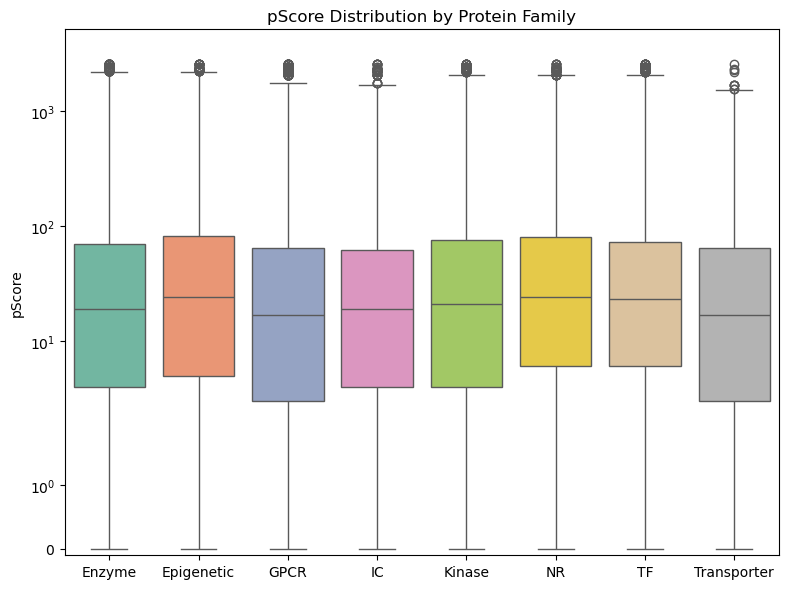

In [53]:
x_col = "protein_family"
hue = x_col
y_col = "pscore"
create_boxplots(scaf2fam_nonan_df, x_col, y_col, x_col, "symlog", "pScore", "pScore Distribution by Protein Family", 
                pallette=fam_colors, whiskers=(0.1, 99.9), ylim=(-0.1, max_pscore * 2), save_fname="pscores_by_family_boxplot.png")

# Close DB Connection

In [54]:
# Close the cursors
db_cur.close()

# Close the connections
db_connection.close()